# Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Import custom image to test model

Load custom image from local context to test model capabilities

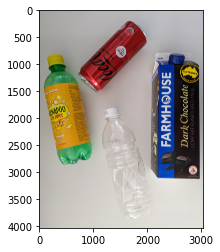

In [2]:
custom_img = '../data/custom/image1.jpeg'

img = cv2.imread(custom_img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img1)
plt.imshow(im_pil)
plt.show()

# Defining the class dictionary

In [3]:
# class_list = ['Background',
#               'Aluminium foil',
#  'Battery',
#  'Aluminium blister pack',
#  'Carded blister pack',
#  'Other plastic bottle',
#  'Clear plastic bottle - PET',
#  'Glass bottle',
#  'Plastic bottle cap - PP',
#  'Metal bottle cap',
#  'Broken glass',
#  'Food Can',
#  'Aerosol',
#  'Drink can',
#  'Toilet tube',
#  'Other carton',
#  'Egg carton',
#  'Drink carton',
#  'Corrugated carton',
#  'Meal carton',
#  'Pizza box',
#  'Paper cup',
#  'Disposable plastic cup',
#  'Foam cup',
#  'Glass cup',
#  'Other plastic cup',
#  'Food waste',
#  'Glass jar',
#  'Plastic lid',
#  'Metal lid',
#  'Other plastic',
#  'Magazine paper',
#  'Tissues',
#  'Wrapping paper',
#  'Normal paper',
#  'Paper bag',
#  'Plastified paper bag',
#  'Plastic film',
#  'Six pack rings',
#  'Garbage bag',
#  'Other plastic wrapper',
#  'Single-use carrier bag',
#  'Polypropylene bag',
#  'Crisp packet',
#  'Spread tub',
#  'Tupperware',
#  'Disposable food container',
#  'Foam food container',
#  'Other plastic container',
#  'Plastic glooves',
#  'Plastic utensils',
#  'Pop tab',
#  'Rope & strings',
#  'Scrap metal',
#  'Shoe',
#  'Squeezable tube',
#  'Plastic straw',
#  'Paper straw',
#  'Styrofoam piece',
#  'Unlabeled litter',
#  'Cigarette']

class_list = ['Background',
              'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Plastic recyclables',
 'Plastic recyclables',
 'Other recyclables',
 'Plastic recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'Other recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'Other recyclables',
 'Plastic recyclables',
 'Other recyclables',
 'Plastic recyclables',
 'Other recyclables',
 'NON-recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'NON-recyclables',
 'Plastic recyclables',
 'Plastic recyclables',
 'NON-recyclables',
 'Other recyclables',
 'NON-recyclables',
 'Plastic recyclables',
 'NON-recyclables',
 'Plastic recyclables',
 'Plastic recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'Plastic recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'Other recyclables',
 'Other recyclables',
 'Other recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables',
 'NON-recyclables']

class_list_no = enumerate(class_list)

class_dict = {}
for i,j in class_list_no:
    class_dict[i] = str(j)

# Establishing the Object Detection Pipeline

Code adapted from [source](https://dida.do/blog/how-to-recognise-objects-in-videos-with-pytorch)

In [4]:
class ObjectDetectionPipeline:
    def __init__(self, threshold=0.5, device="cpu", cmap_name="tab10_r"):

        # omited resizing
        self.tfms = transforms.Compose([
#             transforms.Resize(size=(800)),
            transforms.ToTensor(),
        ])
        
        # Instantiate a model to evaluation mode and sending it to the correct device.
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 61)
    
        # Stop the network from keeping gradients.
        # It's not required but it gives some speedup / reduces memory use.
        for param in self.model.parameters():
            param.requires_grad = False

        # model path
        self.PATH = 'model_35_39.pt'

        self.checkpoint = torch.load(self.PATH, map_location=device)
        self.model.load_state_dict(self.checkpoint['model_state_dict'])
        
        self.device = device
        self.threshold = threshold # Confidence threshold for displaying boxes.
        self.cmap = cm.get_cmap(cmap_name) # colour map
        self.classes_to_labels = class_dict

    
    @staticmethod
    def _crop_img(img):
        """Crop an image or batch of images to square
           Not used in this case but can be considered as an option for consistency"""
        if len(img.shape) == 3:
            y = img.shape[0]
            x = img.shape[1]
        elif len(img.shape) == 4:
            y = img.shape[1]
            x = img.shape[2]
        else:
            raise ValueError(f"Image shape: {img.shape} invalid")
            
        out_size = min((y, x))
        startx = x // 2 - out_size // 2
        starty = y // 2 - out_size // 2
        
        if len(img.shape) == 3:
            return img[0:y, 0:x]
        elif len(img.shape) == 4:
            return img[:, 0:y, 0:x]
        
    def _plot_boxes(self, output_img, labels, boxes):
        """Plot boxes on an image"""
        for label, (x1, y1, x2, y2) in zip(labels, boxes):

            x1 = int(x1.item())
            x2 = int(x2.item())
            y1 = int(y1.item())
            y2 = int(y2.item())

#             print(x1, x2, y1, y2)

            rgba = self.cmap(label.item())
            bgr = rgba[0]*255, rgba[1]*255, rgba[2]*255
            cv2.rectangle(output_img, (x1, y1), (x2, y2), bgr, 5)
            cv2.putText(output_img, self.classes_to_labels[label.item()], 
                        (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 2, bgr, 5)

        return output_img
    
    def __call__(self, img):
        """
        Now the call method This takes a raw frame from opencv finds the boxes and draws on it.
        """
        boxes = 0
        labels = 0
        conf = 0
        
        if type(img) == np.ndarray:
            # single image case
            
            # First convert the image to a tensor, reverse the channels, unsqueeze and send to the right device.
            img_tens = self.tfms(Image.fromarray(img[:,:,::-1])).unsqueeze(0).to(self.device)
        
            # Run the tensor through the network.
            results = self.model(img_tens)
            for result in results:
                boxes = result['boxes'][result['scores'] > self.threshold]
                labels = result['labels'][result['scores'] > self.threshold]
                conf = result['scores'][result['scores'] > self.threshold]
    
            # Crop the image to match what we've been predicting on.
            output_img = self._crop_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#             print(results)
        
            return self._plot_boxes(output_img, labels, boxes)
        
        elif type(img) == list:
            # batch case
            if len(img) == 0:
                # Catch empty batch case
                return None
            
            tens_batch = torch.cat([self.tfms(Image.fromarray(x[:,:,::-1])).unsqueeze(0) for x in img]).to(self.device)
            results = self.model(tens_batch)

            output_imgs = []
            for im, result in zip(img, results):
                boxes = result['boxes'][result['scores'] > self.threshold]
                labels = result['labels'][result['scores'] > self.threshold]
                conf = result['scores'][result['scores'] > self.threshold]
                output_imgs.append(self._plot_boxes(self._crop_img(im), labels, boxes))
                
            return output_imgs
        
        else:
            raise TypeError(f"Type {type(img)} not understood")

# Visualize the results

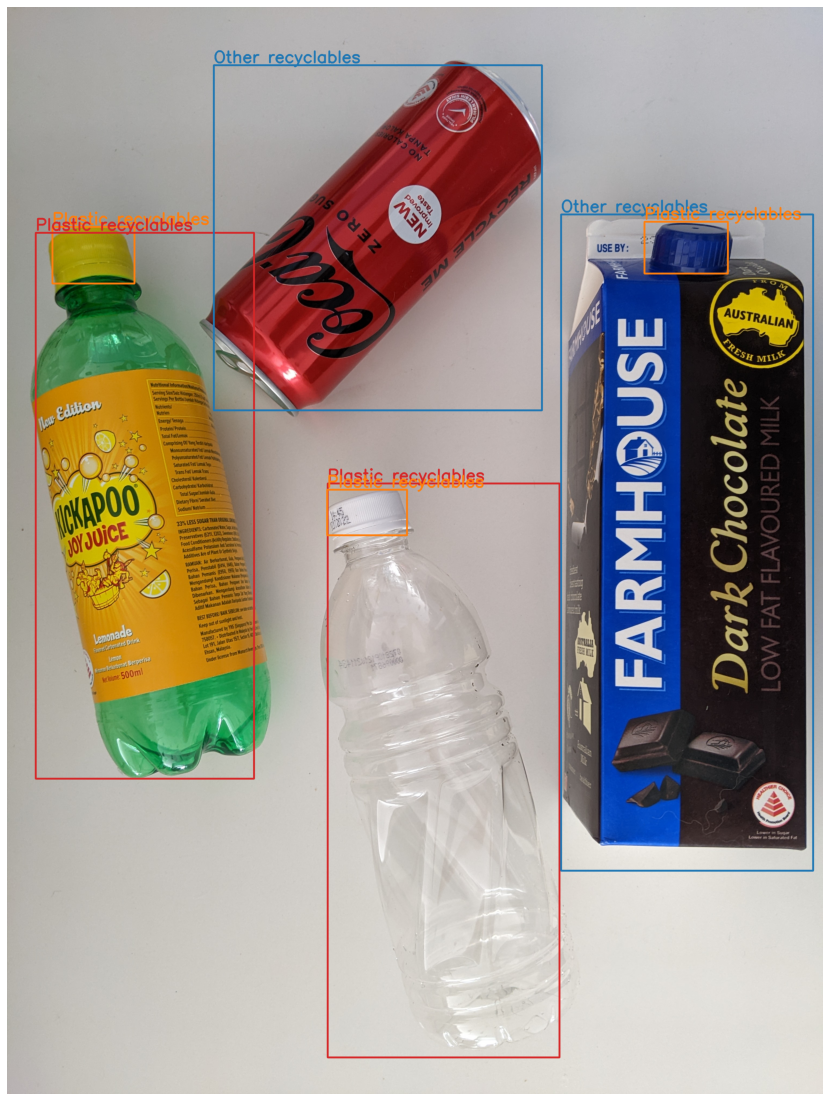

In [6]:
obj_detect = ObjectDetectionPipeline(device="cpu", threshold=0.6)

plt.figure(figsize=(20,20))
plt.imshow(obj_detect(img))
plt.axis('off')
plt.show()